# MATH 497: Final Project

Remark: 
Please use Jupyter Notebook (Final_Project_yourname.ipynb file) to prepare your final
report, including the output of your code, and submit this on Canvas
by 5pm June 26 Friday EST.

Please summarize your results using Tables, plots and bullet-points
for each problem in a concise, clear and coherent manner.  You are
welcome to organize your presentations using your own style if you
prefer, or you can use the following  as a reference to prepare
your presentation. 

You can also use https://www.tablesgenerator.com/markdown_tables to create your own tables.

=================================================================================================================

## Problem 1 [20%]:  

Consider the following linear system

\begin{equation}\label{matrix}
A\ast u =f,
\end{equation}
or equivalently $u=\arg\min \frac{1}{2} (A* v,v)_F-(f,v)_F$, where $(f,v)_F =\sum\limits_{i,j=1}^{n}f_{i,j}v_{i,j}$ is the Frobenius inner product.
Here $\ast$ represents a convolution with one channel, stride one and zero padding one. The convolution kernel $A$ is given by
$$ 
A=\begin{bmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{bmatrix},~~
$$
the solution $ u \in \mathbb{R}^{n\times n} $, and the RHS $ f\in \mathbb{R}^{n\times n}$ is given by $f_{i,j}=\dfrac{1}{(n+1)^2}.$


### Tasks:
Set $J=4$, $n=2^J-1$ and the number of iterations $M=100$. Use the gradient descent method and the multigrid method to solve the above problem with a random initial guess $u^0$. Let $u_{GD}$ and $u_{MG}$ denote the solutions obtained by gradient descent and multigrid respectively.
    
* [5%] Plot the surface of solution $u_{GD}$ and $u_{MG}$.

* [10%] Define error $e_{GD}^m = \|A * u^{m}_{GD}- f\|_F=\sqrt{\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n} |(A * u^{m}_{GD}- f)_{i,j}}|^2 $ for $m=0,1,2,3,...,M$. Similarly, we define the multigrid error $e_{MG}^m$. Plot the errors $e_{GD}^m$ and $e_{MG}^m$ as a function of the iteration $m$ (your x-axis is $m$ and your y-axis is the error). Put both plots together in the same figure.

* [5%] Find the minimal $m_1$ for which $e^{m_1}_{GD} <10^{-5}$ and the minimal $m_2$ for which $e^{m_2}_{MG} <10^{-5}$, and report the computational time for each method. Note that $m_1$ or $m_2$ may be greater than $M=100$, in this case you will have to run more iterations.

### Remark:

Below are examples of using gradient descent and multigrid iterations for M-times 
* #### For gradient descent method with $\eta=\frac{1}{8}$, you need to write a code:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~\text{for    }  i,j = 1: n\\
&~~~~~~~~u_{i,j}^{m} = u_{i,j}^{m-1}-\eta(f_{i,j}-(A\ast u^{m-1})_{i,j})\\
&~~~~\text{endfor}\\
&\text{endfor}
\end{align} 
$$

* #### For multigrid method, we have provided the framework code in F02_MultigridandMgNet.ipynb:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~u^{m} = MG1(u^{m-1},f, J, \nu)\\
&\text{endfor}
\end{align} 
$$

## Results of Problem 1:


### General Code for Both Method

In [2]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)




##### For MG: inilization of A, S, Pi, R, RT #####
def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):

    A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
    S_kernel = torch.tensor([[[[0,1/64,0],[1/64,12/64,1/64],[0,1/64,0]]]],dtype=torch.float32)
    Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
    R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
    RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

    if A is not None:
        A.weight = torch.nn.Parameter(A_kernel)
    
    if S is not None:
        S.weight = torch.nn.Parameter(S_kernel)
        
    if Pi is not None:
        Pi.weight = torch.nn.Parameter(Pi_kernel)
    
    if R is not None:
        R.weight = torch.nn.Parameter(R_kernel)
    
    if RT is not None:
        RT.weight = torch.nn.Parameter(RT_kernel)
    
    return




##### For MG: setup for prolongation and error calculation #####
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        get_mg_init(A=A,S=S)                       ##### For MG: inilization of A, S #####

        self.A = A
        self.S = S

    def forward(self, out):
        u, f = out
        u = u + (self.S(((f-self.A(u)))))          ##### For MG: u = u + S*(f-A*u) #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        get_mg_init(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

    def forward(self, out):
        u_old, f_old = out
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A_old*u_old) + A*u #####       
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u    

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers)) # = do this one by one, but we are not sure about the specific number of l


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MG: padding=0 #####  
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=0, bias=False)
                R  = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=0, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]

    def forward(self, u, f):
     
        out = (u, f) 

        u_list.append(u)                                      ##### For MG: save u^j, j=1,2,...,J #####
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
            u, f = out                                        ##### For MG: save u^j, j=1,2,...,J #####
            u_list.append(u)                                  ##### For MG: save u^j, j=1,2,...,J #####



##### Apply Multigrid to solve the problem
def plot_solution(J,u,label_name):
    N = 2 ** J -1
    h = 1/2**J
    X = np.arange(h, 1, h)
    Y = np.arange(h, 1, h)
    X, Y = np.meshgrid(X,Y)   # create a mesh
    a = torch.reshape(u, (N, N))
    fig1 = plt.figure()
    ax = Axes3D(fig1)         # plot a 3D surface, (X,Y,u(X,Y))
    ax.plot_surface(X, Y, np.array(a.data), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_title(label_name)


def MG1(u,f,J,num_iteration):
    u_list.clear()                                     # Save u^0,u^1,u^2,u^3...,u^J
    u = MG0(u,f)
    for j in range(J-1,0,-1):
        u_list[j] += RT(u_list[j+1])
    u = u_list[1]
    return u


### For Task Three
def plot_error(M,error1,error2,label_name):
    #print(np.linalg.norm((f-self.A(u)).reshape(-1).detach().numpy()))
    plt.figure()
    plt.title('Error vs number of iterations using '+label_name)
    plt.plot(error1)
    plt.plot(error2)
    plt.xlabel('Number of iterations')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.show()


Use GPU? True


### Task 1

#### Gradient Descent Method

##### The plots for task 1; and the specific code of GD method for task 1 and 2.

Total Gradient Descent Computation Time: 0.054399567000473326


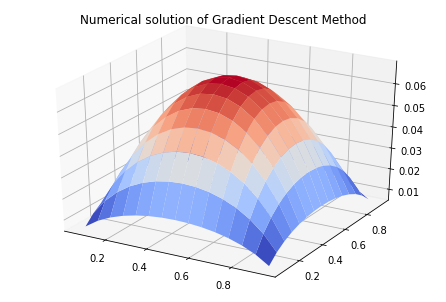

In [51]:
##### Apply to solve the problem

# Model setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 # as required
num_iteration = [2,0,0,0] # For GD
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2

M = 100 # as required
u = torch.randn(1,1,N,N)


##### For Task 2: Iterations for calculating error #####
GD_start = timer()

error_GD = [np.linalg.norm((A(u)-f).detach().numpy())]  # Prepare to store error
u_list =[]                                              # Save u^0,u^1,u^2,u^3...,u^J


for m in range(M):
    u = MG1(u,f,J,num_iteration)
    error_GD.append(np.linalg.norm((A(u)-f).detach().numpy())) # Task 2: calculate the Frobenius Norm of (A*u-f)

GD_end = timer() 


##### Task 1: Added for MG: Plot results #####

plot_solution(J,u,'Numerical solution of Gradient Descent Method')

print('Total Gradient Descent Computation Time:',GD_end - GD_start) 

#### Multigrid Method Method

##### The plots for task 1; and the specific code of GD method for task 1 and 2.

Total Muligrid Computation Time: 0.07072526800038759


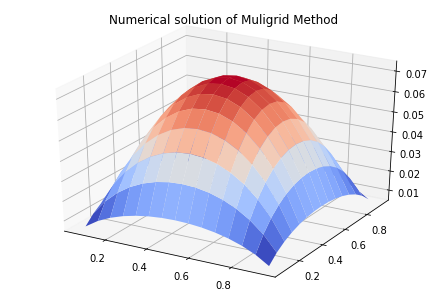

In [52]:
# Model setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 # as required
num_iteration = [2,2,2,2]
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

##### For MG: PDE setup u=sin(2*pi*x)*sin(2*pi*y) #####

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2


##### For MG: Muligrid iteration #####

M = 100 # as required
u = torch.randn(1,1,N,N)


##### For Task 2: Iterations for calculating error #####

error_MG = [np.linalg.norm((A(u)-f).detach().numpy())]  # Prepare to store error
u_list =[]       
                                       # Save u^0,u^1,u^2,u^3...,u^J
MG_start = timer() 

for m in range(M):
    u = MG1(u,f,J,num_iteration)
    error_MG.append(np.linalg.norm((A(u)-f).detach().numpy())) # calculate the Frobenius Norm of (A*u-f)

MG_end = timer()

##### Task 1: Added for MG: Plot results #####

plot_solution(J,u,'Numerical solution of Muligrid Method')
print('Total Muligrid Computation Time:',MG_end - MG_start) 

### Task 2

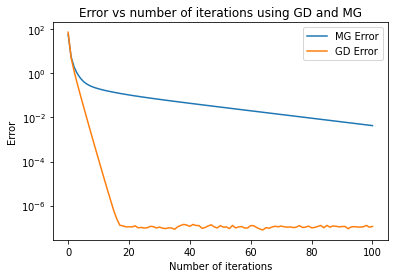

In [25]:
### The plot_error function has already been defined in "General Code" (the first part of answer).

### error_GD and error_MG defined and stored in code of Task 1

plot_error(M,error_GD,"GD Error",error_MG,"MG Error",'GD and MG')

### Task 3


In [49]:
##### Find the miminal m1 of Gradient Descent Method #####

# Model setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 # as required
num_iteration = [2,0,0,0] # For GD
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2

M = 100 # as required
u = torch.randn(1,1,N,N)


GD_start = timer() # To calculate computation time
m1 = 0

while m1 >= 0:
    m1 += 1
    u = MG1(u,f,J,num_iteration)
    error_GD = np.linalg.norm((A(u)-f).detach().numpy()) # To calculate the error: Frobenius Norm of (A*u-f)
    
    if error_GD < 10**(-5):
      break

GD_end = timer()

print("The minial m\N{subscript one} (GD) is", m1)
print('The total computation time of m\N{subscript one} is',GD_end - GD_start) 



##### Find the miminal m2 of Muligrid Method #####

# Model setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 # as required
num_iteration = [2,2,2,2] # MG
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2

M = 100 # as required
u = torch.randn(1,1,N,N)


MG_start = timer() # To calculate computation time
m2 = 0 # 

while m2 >= 0:
    m2 += 1
    u = MG1(u,f,J,num_iteration)
    error_MG = np.linalg.norm((A(u)-f).detach().numpy()) # To calculate the error: Frobenius Norm of (A*u-f)
    
    if error_MG < 10**(-5):
      break

MG_end = timer()

print("The minial m\N{subscript two} (MG) is", m2)
print('The total computation time of m\N{subscript two} is',MG_end - MG_start) 

The minial m₁ (GD) is 213
The total computation time of m₁ is 0.24181445000021995
The minial m₂ (MG) is 13
The total computation time of m₂ is 0.03558339299979707


### Summary

| Method           | $\nu$ or $\eta$ | #iterations | computational time |
|:-----------------|:-----------|:--------------------|:-------------------|
| Gradient Descent |[2, 0, 0, 0]|100               |0.054399567000473326|
| Multigrid        |[2, 2, 2, 2]|100               |0.07072526800038759|

#### $m_1$ = 213, Computation Time = 0.24181445000021995
#### $m_2$ = 13, Computation Time = 0.03558339299979707
\\
### Discussions or Conclusions

#### *  Gradient descent method is a little faster than the Multigrid method.
#### * The error of MG method decreases much faster than GD method during the first 20 iterations, and MG method can also remain in this low error level during the rest iterations, which is 4 orders of magnitude smaller than the final error of GD method.

=================================================================================================================

## Problem 2 [50%]: 

Use SGD with momentum and weight decay to train MgNet on the Cifar10 dataset. Use 120 epochs, set the initial learning rate to 0.1, momentum to 0.9, weight decay to 0.0005, and divide the learning rate by 10 every 30 epochs. (The code to do this has been provided.) Let $b_i$ denote the test accuracy of the model after $i$ epochs, and let $b^*$ = $\max_i(b_i)$ be the best test accuracy attained during training.


### Tasks:
   * [30%] Train MgNet with the following three sets of hyper-parameters (As a reminder, the hyper-parameters of MgNet are $\nu$, the number of iterations of each layer, $c_u$, the number of channels for $u$, and $c_f$, the number of channels for $f$.):
 
    (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.
    
    (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

    (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, try to improve the test accuracy by implementing MgNet with $S^{l,i}$, which means different iterations in the same layer do not share the same $S^{l}$. 
  
  
   * For each numerical experiment above, print the results with the following format:

       "Epoch: i, Learning rate: lr$_i$, Training accuracy: $a_i$, Test accuracy: $b_i$"

        where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch, and lr$_i$ is the learning rate of $i$-th epoch.
    
    
   * [10%] For each numerical experiment above, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. An example plot is shown in the next cell.
   
   
   * [10%] Calculate the number of parameters that each of the above models has. Discuss why the number of parameters is different (or the same) for each of the models.
       

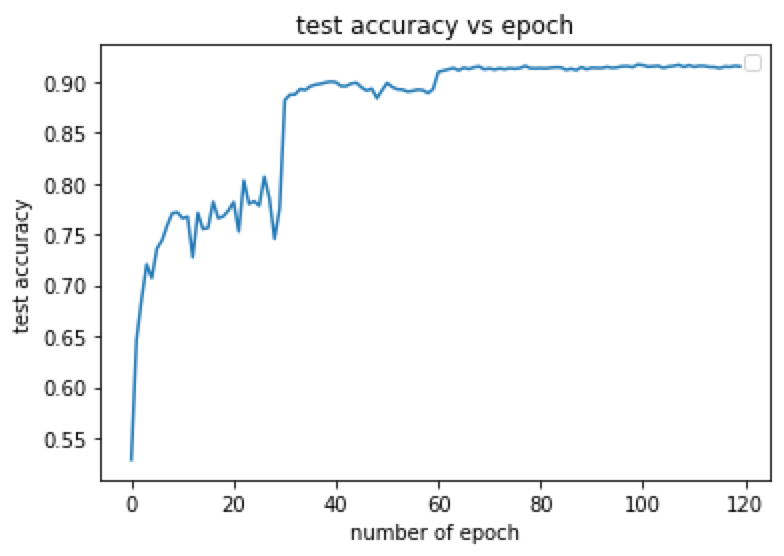

In [ ]:
from IPython.display import Image
Image(filename='plot_sample_code.png')


In [ ]:
# You can calculate the number of parameters of my_model by:
model_size = sum(param.numel() for param in my_model.parameters())


## Results of Problem 2:


### For (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.

### Show your code 
### Show the print and plots 

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Computation Time for training: 22.24622530800025
Computation Time for training accuracy: 14.021310008
Computation Time for test accuracy: 1.8775758849997146
Epoch: 1, learning rate: 0.1, the training accuracy: 0.51748, the test accuracy: 0.52
Computation Time for one epoch: 38.145603811
Computation Time for training: 21.688821007000115
Computation Time for training accuracy: 14.006785988000047
Computation Time for test accuracy: 1.8462573940005313
Epoch: 2, learning rate: 0.1, the training accuracy: 0.6234, the test accuracy: 0.6162
Computation Time for one epoch: 37.542807845000425
Computation Time for training: 21.67136008199941
Computation Time for training accuracy: 14.469576178999887
Computation Time for test accuracy: 1.8390579659999275
Epoch: 3, learning rate: 0.1, the training accuracy: 0.67328, the test accuracy: 0.6729
Computation Time for one epoch: 37.98162528499961
Computation Time fo

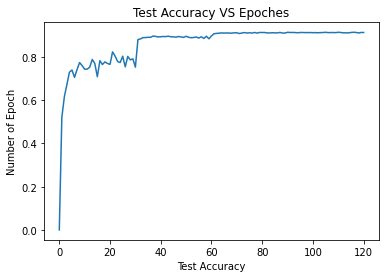

The model has 520394 parameters.


In [12]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
  
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
       
        
        out = (u, f) 

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        

#-------------------------------------------------------------------------------------------------------------------

##### (1)
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10 
num_iteration = [1,1,1,1]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

#Step 4: Train the NNs
plot_accuracy = []
plot_accuracy.append(0)

# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    plot_accuracy.append(test_accuracy)

    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)


##### (2)
plt.figure()
plt.title('Test Accuracy VS Epoches')
plot = plt.plot(plot_accuracy)
plt.xlabel('Test Accuracy')
plt.ylabel('Number of Epoch')
plt.show()

##### (3)
model_size = sum(param.numel() for param in my_model.parameters())
print("The model has", model_size, "parameters.")


### For (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

### Show your code 
### Show the print and plots 

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Computation Time for training: 13.885098167927936
Computation Time for training accuracy: 10.849168706918135
Computation Time for test accuracy: 1.4554361799964681
Epoch: 1, learning rate: 0.1, the training accuracy: 0.45342, the test accuracy: 0.4488
Computation Time for one epoch: 26.189831672003493
Computation Time for training: 13.385887898039073
Computation Time for training accuracy: 10.8574685419444
Computation Time for test accuracy: 1.451854742015712
Epoch: 2, learning rate: 0.1, the training accuracy: 0.52826, the test accuracy: 0.5158
Computation Time for one epoch: 25.69533873803448
Computation Time for training: 13.40402953804005
Computation Time for training accuracy: 10.876706427079625
Computation Time for test accuracy: 1.4618172139162198
Epoch: 3, learning rate: 0.1, the training accuracy: 0.57434, the test accuracy: 0.5518
Computation Time for one epoch: 25.742690531071275
Comput

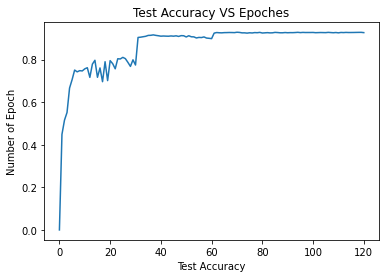

The model has 521418 parameters.


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
  
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
       
        
        out = (u, f) 

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        

    
#-------------------------------------------------------------------------------------------------------------------
    
##### (1)
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10 
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

#Step 4: Train the NNs
plot_accuracy = []
plot_accuracy.append(0)

# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    plot_accuracy.append(test_accuracy)

    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)


##### (2)
plt.figure()
plt.title('Test Accuracy VS Epoches')
plot = plt.plot(plot_accuracy)
plt.xlabel('Test Accuracy')
plt.ylabel('Number of Epoch')
plt.show()

##### (3)
model_size = sum(param.numel() for param in my_model.parameters())
print("The model has", model_size, "parameters.")

### For (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, MgNet with $S^{l,i}$

### Show your code 
### Show the print and plots 

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Computation Time for training: 13.448050512000918
Computation Time for training accuracy: 10.859823570935987
Computation Time for test accuracy: 1.4504202839452773
Epoch: 1, learning rate: 0.1, the training accuracy: 0.48908, the test accuracy: 0.488
Computation Time for one epoch: 25.75842600793112
Computation Time for training: 13.462603608029895
Computation Time for training accuracy: 10.86325802700594
Computation Time for test accuracy: 1.4596118320478126
Epoch: 2, learning rate: 0.1, the training accuracy: 0.61322, the test accuracy: 0.6147
Computation Time for one epoch: 25.785602646064945
Computation Time for training: 13.4790540660033
Computation Time for training accuracy: 10.856138061033562
Computation Time for test accuracy: 1.4521991800284013
Epoch: 3, learning rate: 0.1, the training accuracy: 0.67768, the test accuracy: 0.6742
Computation Time for one epoch: 25.7875189849874
Computat

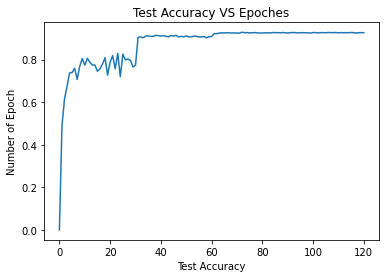

The model has 668874 parameters.


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
  
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))


            setattr(self, 'layer'+str(l), nn.Sequential(*layers))


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
       
        
        out = (u, f) 

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        

    
#-------------------------------------------------------------------------------------------------------------------
    
##### (1)
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10 
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

#Step 4: Train the NNs
plot_accuracy = []
plot_accuracy.append(0)

# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    plot_accuracy.append(test_accuracy)

    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)


##### (2)
plt.figure()
plt.title('Test Accuracy VS Epoches')
plot = plt.plot(plot_accuracy)
plt.xlabel('Test Accuracy')
plt.ylabel('Number of Epoch')
plt.show()

##### (3)
model_size = sum(param.numel() for param in my_model.parameters())
print("The model has", model_size, "parameters.")

### Summary 

#### For all, I run 120 epochs, use 0.1 as the initial learning rate , and divide it by 10 every 30 epochs.

|      Model            | $c_u, c_f$ | $\nu$      | test accuracy $b^*$ |computational time | #parameters |
|:----------------------|:-----------|:-----------|:--------------------|:------------------|:------------|
| MgNet with $S^{l}$    |64, 64      |  [1,1,1,1] | 0.9133              |4519.032257282     |520394          |
| MgNet with $S^{l}$    |64, 64      |  [2,2,2,2] | 0.927               |3151.632476134924  |521418       |
| MgNet with $S^{l,i}$  |64, 64      |  [2,2,2,2] | 0.9265              |3133.9778183799936 |668874       |

\\
### Discussions or Conclusions

#### *  Increasing the number of iteration $ν$  of each layer can improve the accuracy
#### *  The number of parameters is different each time because the iterations increase.

=================================================================================================================

## Problem 3 [25 %]:

Try to improve the MgNet Accuracy by increasing the number of channels. (We use the same notation as in the previous problem.) Double the number of channels to $c_u=c_f=128$ and try different $\nu$ to maximize the test accuracy.

### Tasks:
   * [20%] Report $b^{*}$, $\nu$ and the number of parameters of your model for each of the experiments you run.
   * [5%] For the best experiment, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. (Same as for the previous problem.)

In [ ]:
# You can calculate the number of parameters of my_model by:
model_size = sum(param.numel() for param in my_model.parameters())


## Results of Problem 3:


### Summary 

#### For all, I run 120 epochs, use 0.1 as the initial learning rate , and divide it by 10 every 30 epochs.

|                      | $c_u, c_f$ | $\nu$      | test accuracy $b^*$ |computational time | #parameters |
|:---------------------|:-----------|:-----------|:--------------------|:------------------|:------------|
|MgNet with $S^{l,i}$  |128, 128    |1, 1, 1, 1  |0.9249               |3110.5152489600005 |2072970      |
|MgNet with $S^{l,i}$  |128, 128    |2, 1, 1, 1  |0.932                |3663.3950420590118 |2220938      |
|MgNet with $S^{l,i}$  |128, 128    |2, 2, 1, 1  |0.9364               |15162.121707031998 |2368906      |
|MgNet with $S^{l,i}$  |128, 128    |2, 2, 2, 1  |0.9407               |15293.858322455    |2516874      |
|MgNet with $S^{l,i}$  |128, 128    |2, 2, 2, 2  |0.9424               |3971.3855589549057 |2664842      |



### Discussions or Conclusions

#### *  The test accuracy increase with the number of iteration $ν$ in each layer become larger.
#### *  The value of $ν$ also has a positive relationship with the number of parameters.

### For the best experiment, plot the test accuracy against the epoch count

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Computation Time for training: 20.284006107016467
Computation Time for training accuracy: 10.789706745999865
Computation Time for test accuracy: 1.4491356400540099
Epoch: 1, learning rate: 0.1, the training accuracy: 0.43328, the test accuracy: 0.4415
Computation Time for one epoch: 32.52298440004233
Computation Time for training: 20.470712836948223
Computation Time for training accuracy: 11.030077568953857
Computation Time for test accuracy: 1.4893931819824502
Epoch: 2, learning rate: 0.1, the training accuracy: 0.58526, the test accuracy: 0.5771
Computation Time for one epoch: 32.99032338603865
Computation Time for training: 20.514090209966525
Computation Time for training accuracy: 11.069327916018665
Computation Time for test accuracy: 1.4961911890422925
Epoch: 3, learning rate: 0.1, the training accuracy: 0.5592, the test accuracy: 0.5561
Computation Time for one epoch: 33.079741450957954
Comp

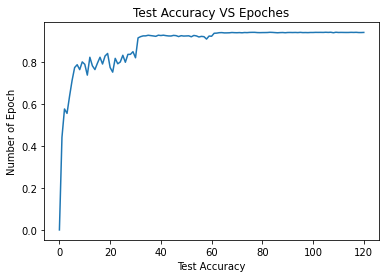

The model has 2664842 parameters.


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
  
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))


            setattr(self, 'layer'+str(l), nn.Sequential(*layers))


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
       
        
        out = (u, f) 

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        

    
#-------------------------------------------------------------------------------------------------------------------
    
##### (1)
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 128
num_channel_f = 128
num_classes = 10 
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

#Step 4: Train the NNs
plot_accuracy = []
plot_accuracy.append(0)

# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    plot_accuracy.append(test_accuracy)

    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)


##### (2)
plt.figure()
plt.title('Test Accuracy VS Epoches')
plot = plt.plot(plot_accuracy)
plt.xlabel('Test Accuracy')
plt.ylabel('Number of Epoch')
plt.show()

##### (3)
model_size = sum(param.numel() for param in my_model.parameters())
print("The model has", model_size, "parameters.")

=================================================================================================================

## Problem 4 [5%]:

Continue testing larger MgNet models (i.e. increase the number of channels) to maximize the test accuracy. (Again, we use the same notation as in problem 2.)

### Tasks:    
    
+  [5%] Try different training strategies and MgNet architectures with the goal of achieving $b^*>$ 95%. Hint: you can tune the number of epochs, the learning rate schedule, $c_u$, $c_f$, $\nu$, try different $S^{l,i}$ in the same layer $l$, etc...

## Results of Problem 4:


### Summary 

#### For all, I use 0.1 as the initial learning rate and divide it by 10 every 30 epochs.


|    | $c_u, c_f$ | $\nu$     | test accuracy $b^*$ |computational time | #parameters|other parameters you tuned|
|:---|:-----------|:----------|:--------------------|:------------------|:-----------|:-------------------------|
|1   |128, 128    |3, 3, 3, 3 |0.9424               |3971.3855589549057 |2664842     |num of epochs = 120  
|2   |128, 128    |2, 2, 2, 2 |0.9322               |5833.902334902086  |2664842     |minibatch size = 512      |
|3   |128, 128    |2, 2, 2, 2 |0.9411               |7991.444063936011  |2664842     |num of epochs = 240       |
|3   |128, 128    |2, 2, 2, 2 |0.8488               |7979.547594912001  |2664842     |scheduler + 240 epochs     |
|4   |256, 256    |2, 2, 2, 2 |0.9496               |16421.273270000936 |10638090    |num of epochs = 240       |
|4   |256, 256    |2, 2, 2, 2 |0.9515               |69098.71824246412  |42509834    |num of epochs = 360       |

\\
### Discussions or Conclusions

#### *  Increasing the number of epoches, $c_u$ the number of channels for  𝑢, and $c_f$ the number of channels for 𝑓 can effectively increase the test accuracy.
#### *  Adding scheduler and increasing minibatch size seems do not work well.

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Computation Time for training: 134.50769280688837
Computation Time for training accuracy: 46.06112219998613
Computation Time for test accuracy: 9.198965371120721
Epoch: 1, learning rate: 0.1, the training accuracy: 0.37788, the test accuracy: 0.38
Computation Time for one epoch: 189.7679150090553
Computation Time for training: 136.43657403998077
Computation Time for training accuracy: 46.241161975078285
Computation Time for test accuracy: 9.22537419013679
Epoch: 2, learning rate: 0.1, the training accuracy: 0.46378, the test accuracy: 0.4787
Computation Time for one epoch: 191.90324079501443
Computation Time for training: 136.81826429022476
Computation Time for training accuracy: 46.383536082925275
Computation Time for test accuracy: 9.249866886995733
Epoch: 3, learning rate: 0.1, the training accuracy: 0.55818, the test accuracy: 0.5566
Computation Time for one epoch: 192.45180268585682
Computati

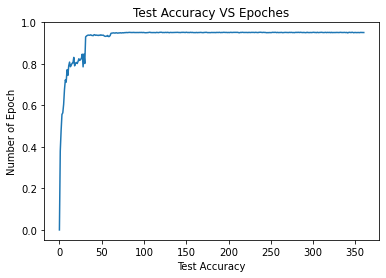

The model has 42509834 parameters.


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
  
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))


            setattr(self, 'layer'+str(l), nn.Sequential(*layers))


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
       
        
        out = (u, f) 

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        

    
#-------------------------------------------------------------------------------------------------------------------
    
##### (1)
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 360
lr = 0.1

num_channel_input = 3
num_channel_u = 512
num_channel_f = 512
num_classes = 10 
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

#Step 4: Train the NNs
plot_accuracy = []
plot_accuracy.append(0)

# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
        # scheduler.step()
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    plot_accuracy.append(test_accuracy)

    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)


##### (2)
plt.figure()
plt.title('Test Accuracy VS Epoches')
plot = plt.plot(plot_accuracy)
plt.xlabel('Test Accuracy')
plt.ylabel('Number of Epoch')
plt.show()

##### (3)
model_size = sum(param.numel() for param in my_model.parameters())
print("The model has", model_size, "parameters.")

=================================================================================================================

## Summary of all the problems

#### Default: 120 epoches; initial learning rate 0.1 and divide by 10 every 30 epoches.

| Model   | $c_u, c_f$ | $\nu$     | test accuracy $b^*$ |computational time | #parameters|other parameters you tuned|
|:---|:-----------|:----------|:--------------------|:------------------|:-----------|:-------------------------|
| MgNet with $S^{l}$    |64, 64      |  [1,1,1,1] | 0.9133              |4519.032257282     |520394          |
| MgNet with $S^{l}$    |64, 64      |  [2,2,2,2] | 0.927               |3151.632476134924  |521418       |
| MgNet with $S^{l,i}$  |64, 64      |  [2,2,2,2] | 0.9265              |3133.9778183799936 |668874       |
|MgNet with $S^{l,i}$  |128, 128     |1, 1, 1, 1  |0.9249               |3110.5152489600005 |2072970      |
|MgNet with $S^{l,i}$  |128, 128     |2, 1, 1, 1  |0.932                |3663.3950420590118 |2220938      |
|MgNet with $S^{l,i}$  |128, 128     |2, 2, 1, 1  |0.9364               |15162.121707031998 |2368906      |
|MgNet with $S^{l,i}$  |128, 128     |2, 2, 2, 1  |0.9407               |15293.858322455    |2516874      |
|MgNet with $S^{l,i}$  |128, 128     |2, 2, 2, 2  |0.9424               |3971.3855589549057 |2664842      |
|MgNet with $S^{l,i}$  |128, 128     |3, 3, 3, 3  |0.9424               |3971.3855589549057 |2664842      |  
|MgNet with $S^{l,i}$  |128, 128     |2, 2, 2, 2  |0.9322               |5833.902334902086  |2664842      |minibatch size = 512      |
|MgNet with $S^{l,i}$  |128, 128     |2, 2, 2, 2  |0.9411               |7991.444063936011  |2664842      |num of epochs = 240       |
|MgNet with $S^{l,i}$  |128, 128     |2, 2, 2, 2  |0.8488               |7979.547594912001  |2664842      |scheduler + 240 epochs    |
|MgNet with $S^{l,i}$  |256, 256     |2, 2, 2, 2  |0.9496               |16421.273270000936 |10638090     |num of epochs = 240       |
|MgNet with $S^{l,i}$  |256, 256     |2, 2, 2, 2  |0.9515               |69098.71824246412  |42509834     |num of epochs = 360       |
